---
title: "Microbial Growth Quantification"
date: 2025-12-05
draft: false
---

# Calculations of Substrate and Production Rates and Yields
This workflow takes growth experiments with complementary substrate concentrations as input and calculates growth and substrate uptake rates. For multiple growth experiments, the user manually stores the rate results of single experiments in a separate standardized Excel sheet to analyze global yields and maintenance cost. 

Additional resources:
 - [Verhulst logical growth equation](https://en.wikipedia.org/wiki/Logistic_function)
 

### Libraries
Loading required libraries for analysis.

 - Input:  None
 - Output: Text: `Libraries loaded.`

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import date
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from iambcodes.rates import *
print("Modules imported successfully.")

Modules imported successfully.


In [2]:
Root_Dir = os.getcwd()
Target_Dir = Root_Dir  # Adjust if needed
File = 'Example_GrowthExp.xlsx' # Add Excel file with growth data
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Define image properties
ImageType = 'svg'      
fontsize = 15
plt.rc('font', size=fontsize)
kwargs = {'mew':5, 'lw':4}

mol2g = {'glc':1/.18, 'glyc':1/.092, 'ace':1/.059, 'eg':1/.0621}
# print plus minus sign
pm = '\u00B1'
print('Definitions done.')

Definitions done.


## Data loading and variables setup

Evaluate the next cell and browse to your Excel sheet. Once evaluated, you can change the source Excel file arbitrarily.

 1. Use the standard format for growth experiments, example file [here](https://git.rwth-aachen.de/ulf.liebal/iambanalyses/-/blob/38cb8d35a01c865e78076217253ee73c4108b367/RatesYields/GrowthExperiment_StandardFormat.xlsx) 
 2. Upload your data in the standard format into the folder `Data/RatesYields`.
 3. Select the file in the browser. 
 
 - Input: Growth rate Excel Sheet
 - Output: None

In [3]:
# General Working Directory
FileAddress = os.path.join(Target_Dir, File)
Xls_df = pd.ExcelFile(FileAddress)
print('Excel sheets:\n{}'.format(Xls_df.sheet_names))



Excel sheets:
['1mM', '2mM', '5mM', '10mM', '20mM', '50mM', 'RateCompare']



 ### Data selection

The sheet with the growth experiment can contain multiple data columns with variable names. The following cell allows you to select first the column for the biomass, and second the column for the substrate concentration. It is also possible to select multiple biomass or substrate concentration columns, if the mean and standard deviation should be used for analysis. Hold `Ctrl` while clicking on the corresponding sheet names. If no conversion factor for OD to gCDW is stored in the metadata of the sheet, you can set the factor.

 - Input:  Sheet names for biomass and substrate (single or multiple)
 - Ouptut: None

In [4]:
# Choosing Excel sheet
Sheet = '10mM' 
# Define conversion factor, e.g. yeast: 0.62 (BNID 111182 in Bionumbers)

# Loading data from sheet into python, ignoring Metadata columns
df_orig = pd.read_excel(FileAddress, sheet_name=Sheet, usecols=lambda x: 'Metadata' not in x,)
df_orig = df_orig.dropna(how = 'all')
DelHeader = df_orig.columns[['Unnamed' in header for header in df_orig.columns]].values
df_orig = df_orig.drop(DelHeader, axis=1)

myMeta = pd.read_excel(FileAddress, sheet_name=Sheet, usecols=lambda x: 'Metadata' in x,)
TimeUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Time unit']['Metadata: Value'].values)
# add a biomass correction factor, e.g. from OD to gCDW, if none set to 1
BiomassUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Biomass unit']['Metadata: Value'].values)
if BiomassUnit == 'OD':
    ODConvert = True
    # read or define existing conversion factor for OD to gCDW/L
    BiomassCorr = myMeta.loc[myMeta['Metadata: Key']=='OD2CDW']['Metadata: Value'].values
    OD2DW = BiomassCorr if BiomassCorr.size > 0 else OD2DW
    BiomassUnit = 'gDW/L'
elif BiomassUnit == 'gDW/L':
    OD2DW = 1.
else:
    print('Use standard abbreviation for biomass unit: gDW/L, OD')
SubstrateUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Substrate unit']['Metadata: Value'].values)# 'mM'
# add a substrate correction factor, e.g. to convert from g/l to mM
SubstrateID = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Substrate']['Metadata: Value'].values).lower()
# conversion of g/l concentration to mmol/l
SubstrateCorr = mol2g[SubstrateID] if SubstrateUnit=='g/L' else 1.
YieldCorr = 1/mol2g[SubstrateID]# if SubstrateUnit=='mM' else 1.

print('Data columns: {}'.format(list(df_orig.columns)))

Data columns: ['time', 'Biomass1', 'Carbon-Substrate1', 'Biomass2', 'Carbon-Substrate2']


Add Excel-sheet column names for biomass and substrate.

In [5]:
# Define the column names of biomass and substrate
# Use list input, e.g., ['Biomass'], for replicates ['Biomass1', 'Biomass2'], these will be combined 
BiomassID =  ['Biomass1','Biomass2']
SubstrateID = ['Carbon-Substrate1','Carbon-Substrate2']

df=df_orig.copy()

if len(BiomassID)>1:
    df['Biomass'] = np.mean(df_orig[BiomassID].values, axis=1)*OD2DW
    df['Biomass_std'] = np.std(df_orig[BiomassID].values, axis=1)*OD2DW
else:
    df['Biomass'] = df_orig[BiomassID]*OD2DW

if len(SubstrateID)>1:
    df['Substrate'] = np.mean(df_orig[SubstrateID].values, axis=1)*SubstrateCorr
    df['Substrate_std'] = np.std(df_orig[SubstrateID].values, axis=1)*SubstrateCorr
else:
    df['Substrate'] = df_orig[SubstrateID]*SubstrateCorr

### Growth rate and substrate uptake rates

The following cell prepares the calculation of the rates. Choose the growth law and the time window for the analysis. The substrate uptake rate is calculated according to the material in the article by [Sato et al. 2016](https://doi.org/10.1371/journal.pgen.1006372) and the [S1](https://doi.org/10.1371/journal.pgen.1006372.s012) and [S2](https://doi.org/10.1371/journal.pgen.1006372.s013) Appendix.

 - Input: Growth law (linearized exponential, Verhulst logarithmic, exponential)
 - Output: Figure files in user format with estimation of growth and substrate rates

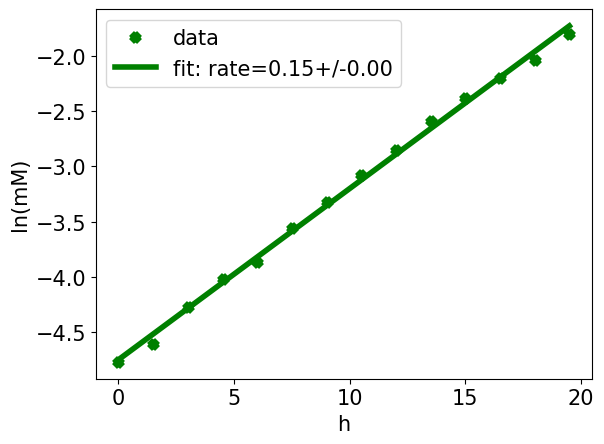

Growth rate fit figure saved as /home/ulf/Documents/BiotechDataAcademy/Website/Jupyter/251211_10mM_lin_GrowthFit.svg


In [10]:
# Choose Growth Law
# Linearized Exponential: 'lex'
# Verhulst Logistic: 'log'
# Exponential: 'exp'
# Linear: 'lin'
BMLaw ='lex'
# Enter the start and end times for exponential growth [1.5,8.6]:
ExpGrwth = [0,20]

inlog = False
if BMLaw == 'lex':
    inlog = True
    BMLaw = 'lin'
p0 = None # enter initial guesses for the logarithmic parameters here


# Extracting data for analysis
ExpGrwth_ind = SubVector(ExpGrwth,df['time'].values)
Time = np.array(df['time'][ExpGrwth_ind]) # - df['time'][ExpGrwth_ind[0]]
Biomass = np.array(df['Biomass'][ExpGrwth_ind], dtype=float)
Substrate = np.array(df['Substrate'][ExpGrwth_ind])
                 
# Calculating growth rate
Bm_sl, Bm_sl_sterr, Bm_ic, Bm_lim = FitGrowth(Time, Biomass, law=BMLaw, inlog=inlog, p0=p0)
PlotPar = [Bm_sl, Bm_ic, Bm_lim] if BMLaw=='log' else [Bm_sl, Bm_ic]
r2_BM, _ = FitR2(Time, Biomass, PlotPar, law=BMLaw, inlog=inlog)

# Biomass plot
FigureGrowth = '{}_{}_{}_GrowthFit.{}'.format(Today, Sheet, BMLaw, ImageType)
FigureGrowthPath = os.path.join(Target_Dir, FigureGrowth)
PlotFit(Time, Biomass, PlotPar, Bm_sl_sterr, [TimeUnit, BiomassUnit], law=BMLaw, inlog=inlog, export_file=FigureGrowthPath, kwargs=kwargs)
plt.ylabel('ln(mM)')
plt.show()
print('Growth rate fit figure saved as {}'.format(FigureGrowthPath))




<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_9954/3418853138.py:28: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$ Biomass, gDW/L')


Growth rate: 0.15(±0.0) /h, with R2: 1.0
Substrate uptake: 2.56(±0.06) mmol/gCDW/h (check units), with R2: 1.0
Biomass yield: 0.33±0.01 gDW/g


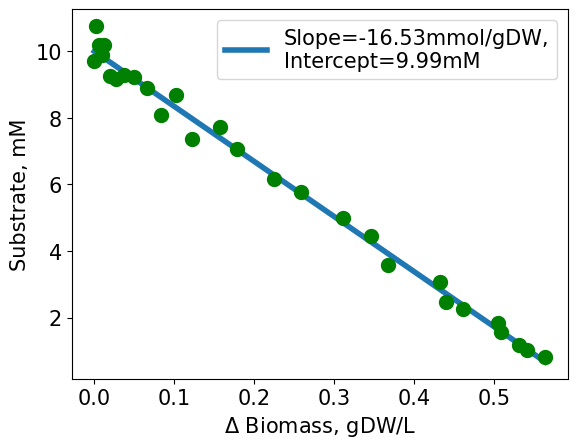

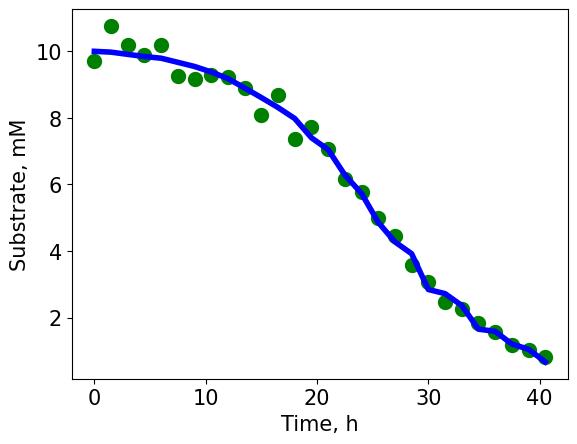

In [13]:

# Calculating substrate uptake rate
DeltaBm = np.array(df['Biomass']-df['Biomass'][0], dtype=float)
Sub_sl, Sub_ic, Sub_r, _, Sub_sl_sterr = stats.linregress(DeltaBm, df['Substrate'])
SubUp = round(-Sub_sl*Bm_sl,2)
SubUp_sterr = round(SubUp*np.sqrt( (Sub_sl_sterr/Sub_sl)**2 + (Bm_sl_sterr/Bm_sl)**2 ), 2)

# r2 calculation
r2_Sub, _ = FitR2(df['Substrate'], DeltaBm, [Sub_sl, Sub_ic], law='lin', inlog=False)

# yield calculation
Yield = round(Bm_sl,2) / (SubUp * YieldCorr) 
# calculating the standard error of the yield based on gaussian error propagation
Yield_sterr = round(Yield*np.sqrt( (SubUp_sterr/SubUp)**2 + (Bm_sl_sterr/Bm_sl)**2 ), 2)

print(f'Growth rate: {round(Bm_sl,2)}({pm}{round(Bm_sl_sterr,2)}) /{TimeUnit}, with R2: {round(r2_BM,2)}')
print(f'Substrate uptake: {SubUp}({pm}{SubUp_sterr}) mmol/gCDW/h (check units), with R2: {round(abs(Sub_r),2)}')
print(f'Biomass yield: {round(Yield,2)}{pm}{Yield_sterr} gDW/g')

FigureSub1 = '{}_{}_{}_SubFit1.{}'.format(Today, Sheet, BMLaw, ImageType)
FigureSub2 = '{}_{}_{}_SubFit2.{}'.format(Today, Sheet, BMLaw, ImageType)
FigureSubPath1 = os.path.join(Target_Dir, FigureSub1)
FigureSubPath2 = os.path.join(Target_Dir, FigureSub2)
# Substrate plots
LinReg = lambda x, m, b: m*x + b
plt.plot(DeltaBm, LinReg(DeltaBm, Sub_sl, Sub_ic), **kwargs)
plt.plot(DeltaBm, df['Substrate'],'go', **kwargs)
plt.legend([f'Slope={Sub_sl:.2f}mmol/gDW,\nIntercept={Sub_ic:.2f}mM'])
plt.xlabel('$\Delta$ Biomass, gDW/L')
plt.ylabel('Substrate, mM')
plt.savefig(FigureSubPath1)
plt.show()

plt.plot(df['time'], df['Substrate'], 'og', label='Substrate', **kwargs)
plt.plot(df['time'], Sub_ic+Sub_sl*DeltaBm, '-b', label=f'fit, rate={SubUp}{pm}{SubUp_sterr}mmol/gCDW/h', **kwargs)
plt.xlabel(f'Time, {TimeUnit}')
plt.ylabel('Substrate, mM')
# plt.legend()
plt.savefig(FigureSubPath2)
plt.show()




## Calculation of growth rate sensitivity to substrate uptake

In [18]:
Sheet = 'RateCompare' # Choose Excel sheet
RateComp = pd.read_excel(FileAddress, sheet_name=Sheet)
print('Data columns in Excel sheet:\n{}'.format(RateComp.columns))
print('Available growth experiments:\n{}'.format(RateComp['ID'].values))
# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Figure files
FigureAccel = '{}_{}_GrowthVsSubRate.{}'.format(Today, os.path.splitext(os.path.split(File)[1])[0], ImageType)
FigureAccelPath = os.path.join(Target_Dir, FigureAccel)

InhibitCorrFig = '{}_{}_SubRateVSInitSub.{}'.format(Today, os.path.splitext(os.path.split(File)[1])[0], ImageType)
InhibitCorrPath = os.path.join(Target_Dir, InhibitCorrFig)

Data columns in Excel sheet:
Index(['ID', 'Comment', 'Tspan', 'BMLaw', 'Substrate', 'Rct-Name',
       'Initial Conc[g/L]', 'Growth-Rate[/h]', 'Growth-Std', 'R2-BM',
       'Substrate-uptake[mmol/gCDW/h]', 'Uptake-Std', 'R2-Sub', 'Yield[g/g]'],
      dtype='object')
Available growth experiments:
['1mM' '2mM' '5mM' '10mM' '20mM' '50mM']


Yield: 0.37 gCDW/g (+/-0.02) and R2: 0.99
NGAM glucose requirement: 0.25 mmol/gCDW/h+/-0.02


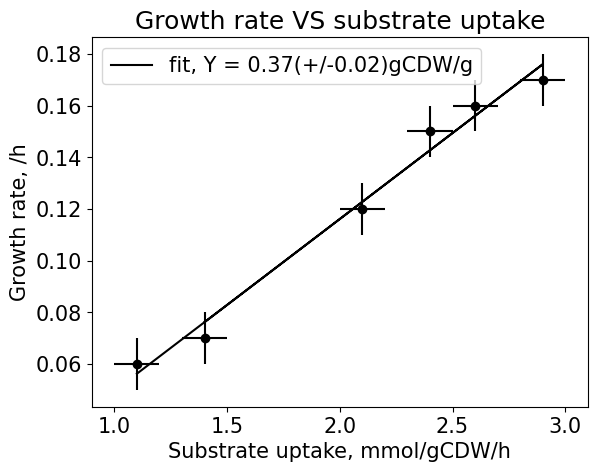

Growth rate versus substrate uptake figure saved as /home/ulf/Documents/BiotechDataAcademy/Website/Jupyter/251211_Example_GrowthExp_GrowthVsSubRate.svg


In [19]:
# Decide which substrate to examine, glucose: glc, glycerol: glyc, acetate: ace
SubType = 'glc'
SubUnit = 'g/L'
SubstrateCorr =  [mol2g[SubType]  if SubUnit=='g/L' else 1.]
# Data rows to be ignored, list with names according to ID column e.g. [], or ['2229v1','Wierckx_50glc']
IgnoreDat = ['v1c']
# Define names of columns for analysis
GrowthMean = 'Growth-Rate[/h]'
GrowthStdv = 'Growth-Std'
SubstrMean = 'Substrate-uptake[mmol/gCDW/h]'
SubstrStdv = 'Uptake-Std'
SubstrInit = 'Initial Conc[g/L]'

# finding data rows with substrate to be checked
DelSub = RateComp[RateComp['Substrate'] != SubType].index
DelID = np.ravel([list(RateComp.index[IgnoreCheck == RateComp['ID']]) for IgnoreCheck in IgnoreDat])
DelRows = np.hstack([DelSub, DelID])

# ignoring any data points
if DelRows is not None:
    RateComp_corr = RateComp.drop(DelRows)
else:
    RateComp_corr = RateComp
    
GrowthVal = RateComp_corr[GrowthMean].values
SubVal = RateComp_corr[SubstrMean].values
GVstd =  RateComp_corr[GrowthStdv].values
SVstd = RateComp_corr[SubstrStdv].values

Yield, S0, r2, _, Yield_sterr = stats.linregress(SubVal, GrowthVal)
Yield_gg = round(Yield/.18,2)
Yield_sterr_gg = round(Yield_sterr/.18,2)
# calculation of NGAM via the substrate uptake at zero growth, 
# Growth = Yield*SubUp + Int -> Growth=0, then SubUp(Growth=0) = -Int / Yield
NGAM = round(-S0/Yield,2)
NGAM_std = round((-S0/(Yield-Yield_sterr) - -S0/(Yield+Yield_sterr))/2,2)
print('Yield: {} gCDW/g (+/-{}) and R2: {}'.format(Yield_gg, Yield_sterr_gg, round(r2,2)))
print('NGAM glucose requirement: {} mmol/gCDW/h+/-{}'.format(NGAM, NGAM_std))
# Growth rate VS Substrate uptake plot
plt.errorbar(SubVal, GrowthVal, xerr=SVstd, yerr=GVstd, fmt='ok') #, 'xk', label='Substrate uptake'
plt.plot(SubVal, S0+Yield*SubVal, '-k', label='fit, Y = {}(+/-{})gCDW/g'.format(Yield_gg, Yield_sterr_gg))
plt.title('Growth rate VS substrate uptake')
plt.xlabel('Substrate uptake, mmol/gCDW/h')
plt.ylabel('Growth rate, /h')
plt.legend()
plt.savefig(FigureAccelPath)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(FigureAccelPath))


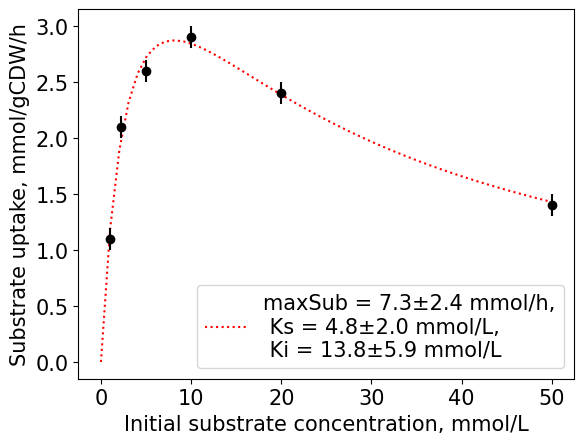

Growth rate versus substrate uptake figure saved as /home/ulf/Documents/BiotechDataAcademy/Website/Jupyter/251211_Example_GrowthExp_SubRateVSInitSub.svg


In [ ]:
###############################
# Plot of initial substrate concentration versus substrate uptake rate
###############################
InitSub = RateComp_corr[SubstrInit].values#*SubstrateCorr[0]
GrVal = RateComp_corr[GrowthMean].values # 
Grstd = RateComp_corr[GrowthStdv].values
SubVal = RateComp_corr[SubstrMean].values
SVstd = RateComp_corr[SubstrStdv].values

# define michaelis menten equation with lambda
MiMe = lambda x, Vmax, Ks: Vmax * x / (Ks + x)
NCOMP = lambda x, Vmax, Ks, Ki: Vmax * x / (Ks + x) / (1 + x/Ki)
# curve fitting
popt, pcov = curve_fit(NCOMP, InitSub, SubVal, sigma=SVstd, absolute_sigma=True)
# popt, pcov = curve_fit(MiMe, InitSub, GrVal, sigma=GVstd, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

# Estimate the parameters of the hyperbolic curve
Vmax = popt[0]
# standard deviation of the Vmax
Vmax_std = perr[0]
# Michaelis-Menten constant
Ks = popt[1]
# standard deviation of the Km
Ks_std = perr[1]
# Inhibition constant
Ki = popt[2]
# standard deviation of the Ki
Ki_std = perr[2]

# generating sample concentration values for the plot
x = np.linspace(0, np.max(InitSub), 50)
# Plot the transformed data and the fitted curve
plt.plot(x, NCOMP(x, Vmax, Ks, Ki), ':r', label=f'maxSub = {Vmax:.1f}±{Vmax_std:.1f} mmol/h,\n Ks = {Ks:.1f}±{Ks_std:.1f} mmol/L,\n Ki = {Ki:.1f}±{Ki_std:.1f} mmol/L')
# plt.plot(x, MiMe(x, Vmax, Ks), ':r', label=f'$\mu$max = {Vmax:.2f}±{Vmax_std:.2f} /h, Ks = {Ks:.2f}±{Ks_std:.2f} g/L')


# Initial substrate concentration VS substrate uptake plot
plt.errorbar(InitSub, SubVal, yerr=SVstd, fmt='ok') #, 'xk', label='Substrate uptake'
plt.xlabel('Initial substrate concentration, mmol/L')
plt.ylabel('Substrate uptake, mmol/gCDW/h')
plt.legend()
plt.savefig(InhibitCorrPath)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(InhibitCorrPath))